# Jit comtpatible critical gradient #

## Imports and basic functions ##

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid


import desc.io
from desc.equilibrium.coords import get_rtz_grid
from desc.grid import Grid, LinearGrid
# from desc.compute.utils import dot
from desc.backend import jnp, jit, functools
from desc.plotting import plot_surfaces
from desc.examples import get
from desc.utils import take_mask


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.12.2+414.g006934812.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 23.52 GB available memory


In [2]:
# Function to get value of a parameter directly
def get_value(eq,name,grid):
    return eq.compute(name,grid=grid)[name]

# @jit
def get_arc_length (diff_l,grid):
    # Integrate differential length along field line with respect to zeta
    return cumulative_trapezoid(diff_l,x=grid.source_grid.nodes[:,2],initial=0)

# Function to get the straight field line coordinate system, need iota for jit
@functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_field_line_grid(eq,iota,rho=0.5,alpha=0,n_pol = 4,n_points = 200):
    n_tor = n_pol/(iota*eq.NFP)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0,2*n_tor*jnp.pi,n_points*n_pol),
        coordinates="raz",
        iota = iota,
        period=(jnp.inf,2*jnp.pi,jnp.inf),
    )
    return good_grid

@jit
def get_drift_curvature(eq,grid):
    cvdrift = get_value(eq,"cvdrift",grid=grid)
    a = get_value(eq,"a",grid=grid)
    B = get_value(eq,"|B|",grid=grid)
    drift_curvature = a**2*jnp.multiply(cvdrift,B)
    # drift_curvature = cvdrift
    return drift_curvature,a



## Masks and data extraction ##

In [8]:
@jit
def old1_create_well_masks(Kd):
    # Get positvie and negatvie regions as well as 0 crossings

    # Step 1: Identify the sign of the first element
    sign_0 = jnp.sign(Kd[0])
    signs = jnp.sign(Kd)

    # Step 2: Create masks based on the sign of Kd
    mask_bad = signs == sign_0    # Mask for values with the same sign as Kd[0]
    mask_good = signs != sign_0   # Mask for values with the opposite sign as Kd[0]

    # Step 3: Compute zero crossings as a boolean array
    sign_changes = signs[:-1] * signs[1:] < 0

    # Create a mask of the same size as the input array
    mask_zeros = jnp.zeros_like(Kd, dtype=bool)

    # Set True for the points where the *next* element changes sign
    mask_zeros = mask_zeros.at[:-1].set(sign_changes)

    masks = {
        "zeros" : mask_zeros,
        "bad"   : mask_bad,
        "good"  : mask_good,
    }

    return masks

In [6]:
def old1_plot_masks(Kd):
    masks = old1_create_well_masks(Kd)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(Kd, label='Kd', color='orange')

    # Define colors and labels for different masks
    mask_info = {
        "good": {"color": "green", "label": "Good Points"},
        "bad": {"color": "blue", "label": "Bad Points"},
        "zeros": {"color": "red", "label": "Zero Points"}
    }

    # Iterate over masks and plot corresponding points
    for mask_key, mask in masks.items():
        plt.scatter(jnp.arange(len(Kd))[mask], Kd[mask], 
                    color=mask_info[mask_key]["color"], 
                    label=mask_info[mask_key]["label"], 
                    zorder=5)

    # Add labels and legend
    plt.title('Kd with Good, Bad, and Zero Points')
    plt.xlabel('Index')
    plt.ylabel('Kd Value')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
@jit
def old2_create_well_masks(Kd):
    # Step 1: Identify sign changes in Kd
    signs = jnp.sign(Kd)
    
    # Create masks for positive and negative crossings of the same size as Kd
    positive_crossings = jnp.zeros_like(Kd, dtype=bool)
    negative_crossings = jnp.zeros_like(Kd, dtype=bool)

    # Set negative crossings (from positive to negative)
    negative_crossings = negative_crossings.at[:-1].set((signs[:-1] == 1) & (signs[1:] == -1))

    # Set positive crossings (from negative to positive)
    positive_crossings = positive_crossings.at[:-1].set((signs[:-1] == -1) & (signs[1:] == 1))

    # Masks for good and bad points
    mask_good = Kd >= 0  # Same sign as Kd[0]
    mask_bad = ~mask_good

    # Store masks in a dictionary
    masks = {
        "bad": mask_bad,
        "good": mask_good,
        "positive_crossings": positive_crossings,
        "negative_crossings": negative_crossings,
    }
    
    return masks

In [4]:
def old2_plot_masks(Kd):
    # Generate masks
    masks = old2_create_well_masks(Kd)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(Kd, label='Kd', color='blue', marker='o')

    # Define colors and labels for different masks
    mask_info = {
        "good": {"color": "green", "label": "Good Points"},
        "bad": {"color": "orange", "label": "Bad Points"},
        "positive_crossings": {"color": "cyan", "label": "Positive Crossings"},
        "negative_crossings": {"color": "magenta", "label": "Negative Crossings"}
    }

    # Iterate over masks and plot corresponding points
    for mask_key, mask in masks.items():
        if mask_key in ["positive_crossings", "negative_crossings"]:
            # Get the indices for crossings, adjusting for plotting
            indices = jnp.arange(len(Kd))[mask]
            plt.scatter(indices, Kd[indices], 
                        color=mask_info[mask_key]["color"], 
                        label=mask_info[mask_key]["label"], 
                        zorder=5)
        else:
            plt.scatter(jnp.arange(len(Kd))[mask], Kd[mask], 
                        color=mask_info[mask_key]["color"], 
                        label=mask_info[mask_key]["label"], 
                        zorder=5)

    # Add labels and legend
    plt.title('Kd with Good, Bad, Positive, and Negative Crossings')
    plt.xlabel('Index')
    plt.ylabel('Kd Value')
    plt.legend()
    plt.grid()
    plt.show()

In [77]:
@functools.partial(jit,static_argnames="n_wells")
def create_well_masks(Kd,n_wells=10):
    # Step 1: Identify sign changes in Kd
    signs = jnp.sign(Kd)
    
    # Create masks for positive and negative crossings of the same size as Kd
    positive_crossings = jnp.zeros_like(Kd, dtype=bool)
    negative_crossings = jnp.zeros_like(Kd, dtype=bool)

    # Set negative crossings (from positive to negative)
    negative_crossings = negative_crossings.at[:-1].set((signs[:-1] == 1) & (signs[1:] == -1))

    # Set positive crossings (from negative to positive)
    positive_crossings = positive_crossings.at[:-1].set((signs[:-1] == -1) & (signs[1:] == 1))

    n_pos = positive_crossings.sum()
    n_neg = negative_crossings.sum()

    n_well_real = (n_pos+n_neg-1)//2

    # Masks for good and bad points
    mask_good = Kd >= 0  # Same sign as Kd[0]
    mask_bad = ~mask_good

    # Create cumulative sums for positive and negative crossings
    cumulative_positive = jnp.cumsum(positive_crossings)
    cumulative_negative = jnp.cumsum(negative_crossings)

    # Create a mask that identifies the range between positive and negative crossings
    in_well = (cumulative_positive < cumulative_negative)

    lengths_pos = jnp.zeros(n_wells, dtype=int)
    lengths_neg = jnp.zeros(n_wells, dtype=int)
    lengths_wells = jnp.zeros(n_wells, dtype=int)
    masks_wells = jnp.zeros((n_wells, Kd.shape[0]), dtype=Kd.dtype)
    Kd_wells = jnp.zeros((n_wells, Kd.shape[0]), dtype=Kd.dtype)  # Initialize with zeros

    # Use a loop to fill the lengths array
    for i in range(1,n_wells):
        lengths_pos = lengths_pos.at[i].set((cumulative_positive == i).sum())
        lengths_neg = lengths_neg.at[i].set((cumulative_negative == i).sum())

        well_mask = (cumulative_negative == i) & (cumulative_negative == cumulative_positive)
        lengths_wells = lengths_wells.at[i].set(well_mask.sum())
        
        # lengths_wells = lengths_wells.at[i].set(((cumulative_negative == i) & (cumulative_negative == cumulative_positive)).sum())
        # Fill the corresponding row in the masks array
        masks_wells = masks_wells.at[i].set(well_mask.astype(Kd.dtype))  # Store mask as row
        well_values = take_mask(Kd, well_mask, fill_value=0)
        # Store the well values in the corresponding row
        Kd_wells = Kd_wells.at[i, :well_values.size].set(well_values)


    cumulatives = {
        "cum_pos" : cumulative_positive,
        "cum_neg" : cumulative_negative,
    }

    lengths = {
        "lengths_pos" : lengths_pos,
        "lengths_neg" : lengths_neg,
        "lengths_wells" : lengths_wells,
    }

    # Store masks in a dictionary
    masks = {
        "bad": mask_bad,
        "good": mask_good,
        "positive_crossings": positive_crossings,
        "negative_crossings": negative_crossings,
        "wells" : masks_wells,
    }
    
    return masks, lengths, cumulatives, Kd_wells

## Extracting ##

In [361]:
@functools.partial(jit,static_argnames=["n_wells","order"])
def extract_Kd_old(Kd,n_wells=10,order=False):
    # Step 1: Identify sign changes in Kd
    signs = jnp.sign(Kd)
    
    # Create masks for positive and negative crossings of the same size as Kd
    positive_crossings = jnp.zeros_like(Kd, dtype=bool)
    negative_crossings = jnp.zeros_like(Kd, dtype=bool)

    # Set negative crossings (from positive to negative)
    negative_crossings = negative_crossings.at[:-1].set((signs[:-1] == 1) & (signs[1:] == -1))

    # Set positive crossings (from negative to positive)
    positive_crossings = positive_crossings.at[:-1].set((signs[:-1] == -1) & (signs[1:] == 1))

    # Create cumulative sums for positive and negative crossings
    cumulative_positive = jnp.cumsum(positive_crossings)
    cumulative_negative = jnp.cumsum(negative_crossings)

    Kd_wells = jnp.zeros((n_wells, Kd.shape[0]), dtype=Kd.dtype)  # Initialize with zeros
    lengths_wells = jnp.zeros(n_wells, dtype=int)

    # Use a loop to fill the lengths array
    for i in range(n_wells):
        # Create well masks
        well_mask = (cumulative_negative == i) & (cumulative_negative > 0) & (cumulative_negative == cumulative_positive)          
        # Fill the corresponding row in the masks array
        well_values = take_mask(Kd, well_mask, fill_value=0)
        # Store the well values in the corresponding row
        Kd_wells = Kd_wells.at[i, :well_values.size].set(well_values)
        lengths_wells = lengths_wells.at[i].set(well_mask.sum())

    if order : 
        # Sort wells by lengths
        sort_indices = jnp.argsort(lengths_wells)[::-1]  # Descending order
        Kd_wells = Kd_wells[sort_indices]
        lengths_wells = lengths_wells[sort_indices]

    return Kd_wells, lengths_wells

In [333]:
def plot_wells(Kd, n_wells=10, order = False):
    Kd_wells, lengths = extract_Kd_old(Kd,n_wells=n_wells, order=order)
    plt.figure()
    for i in range(1,n_wells):
        plt.plot(Kd_wells[i][0:lengths[i]],label=f'well {i}, length = {lengths[i]}')
    plt.legend()

def plot_all(Kd,n_wells=10):
    masks, lengths, _, Kd_wells = create_well_masks(Kd,n_wells=n_wells)
    plt.figure()
    plt.title("masks")  
    for i in range(1,n_wells):
        plt.plot(masks["wells"][i],label=f'Well nr {i}')
    plt.legend()
    plt.figure()
    plt.title("wells")  
    for i in range(1,n_wells):
        plt.plot(Kd_wells[i][0:lengths["lengths_wells"][i]],label=f'well {i}, length = {lengths["lengths_wells"][i]}')
    plt.legend()


## Fitting ##

In [36]:
@functools.partial(jit,static_argnames=["n_wells","n_return","order"])
def extract_Kd(Kd,n_wells=10,n_return=5,order=False):
    # Step 1: Identify sign changes in Kd
    signs = jnp.sign(Kd)
    
    # Create masks for positive and negative crossings of the same size as Kd
    positive_crossings = jnp.zeros_like(Kd, dtype=bool)
    negative_crossings = jnp.zeros_like(Kd, dtype=bool)

    # Set negative crossings (from positive to negative)
    negative_crossings = negative_crossings.at[:-1].set((signs[:-1] == 1) & (signs[1:] == -1))

    # Set positive crossings (from negative to positive)
    positive_crossings = positive_crossings.at[:-1].set((signs[:-1] == -1) & (signs[1:] == 1))

    # Create cumulative sums for positive and negative crossings
    cumulative_positive = jnp.cumsum(positive_crossings)
    cumulative_negative = jnp.cumsum(negative_crossings)

    Kd_wells = jnp.zeros((n_wells, Kd.shape[0]), dtype=Kd.dtype)  # Initialize with zeros
    lengths_wells = jnp.zeros(n_wells, dtype=int)
    masks_wells = jnp.zeros((n_wells, Kd.shape[0]), dtype=Kd.dtype)

    # Use a loop to fill the lengths array
    for i in range(1,n_wells+1):
        # Create well masks
        well_mask = (cumulative_negative == i) & (cumulative_negative == cumulative_positive)        
        # Fill the corresponding row in the masks array
        well_values = jnp.where(well_mask,Kd,0)
        # Store the well values in the corresponding row
        Kd_wells = Kd_wells.at[i-1, :well_values.size].set(well_values)
        masks_wells = masks_wells.at[i-1, :well_values.size].set(well_mask.astype(Kd.dtype))  # Store mask as row
        lengths_wells = lengths_wells.at[i-1].set(well_mask.sum())

    if order : 
        # Sort wells by lengths
        sort_indices = jnp.argsort(lengths_wells)[::-1]  # Descending order
        Kd_wells = Kd_wells[sort_indices]
        lengths_wells = lengths_wells[sort_indices]

    

    return Kd_wells[0:n_return], lengths_wells[0:n_return], masks_wells[0:n_return]

In [6]:
@jit
def weighted_least_squares(l, Kd, mask):
    """
    Perform a weighted least-squares quadratic fit:
    Kd(l) = R_eff_inv * (1 - (l - lc)^2 / ln^2)
    using only the values where the mask is True.

    Parameters:
    -----------
    l : jnp.ndarray
        The coordinate array for the well.
    Kd : jnp.ndarray
        The Kd values along the well.
    mask : jnp.ndarray (bool)
        A mask indicating the valid part of the well.

    Returns:
    --------
    R_eff_inv, ln_squared : float
        Fitted parameters for the quadratic fit.
    """
    # Apply mask to select only valid entries (replace invalid ones with 0)
    weights = mask.astype(float)  # Weight of 1 for valid entries, 0 for invalid

    # Calculate the center of the well (l_c) using only valid entries
    lc = jnp.sum(l * weights) / jnp.sum(weights)

    # Shift the coordinates around the center (l - lc)
    l_shifted = l - lc

    # Build the design matrix A
    A = jnp.stack([-jnp.ones_like(l), l_shifted**2], axis=-1)

    # Apply weights to both A and Kd to exclude invalid entries
    A_weighted = A * weights[:, None]
    Kd_weighted = Kd * weights

    # Solve the least-squares problem: A @ [R_eff_inv, R_eff_inv/ln^2] = Kd
    coeffs, _, _, _ = jnp.linalg.lstsq(A_weighted, Kd_weighted, rcond=None)

    R_eff_inv = coeffs[0]
    ln_squared = R_eff_inv / coeffs[1]
    return R_eff_inv, ln_squared

@functools.partial(jit, static_argnames="n_wells")
def fit_wells(l, Kd_wells, masks, n_wells=10):
    """
    Fit the quadratic function to each well using masks.

    Parameters:
    -----------
    l : jnp.ndarray
        The coordinate array (same for all wells).
    Kd_wells : jnp.ndarray
        2D array containing the Kd values for each well.
    masks : jnp.ndarray
        2D boolean array containing the mask for each well.
    n_wells : int
        Number of wells to fit.

    Returns:
    --------
    R_eff_inv_array, ln_squared_array : jnp.ndarray
        Arrays containing the fitted parameters for each well.
    """
    R_eff_inv_array = jnp.zeros(n_wells)
    ln_squared_array = jnp.zeros(n_wells)

    for i in range(n_wells):
        # Extract the mask for the current well
        well_mask = masks[i]

        # Perform the weighted least-squares fit using the mask
        R_eff_inv, ln_squared = weighted_least_squares(l, Kd_wells[i], well_mask)

        # Store the results
        R_eff_inv_array = R_eff_inv_array.at[i].set(R_eff_inv)
        ln_squared_array = ln_squared_array.at[i].set(ln_squared)
    
    R_eff_array = jnp.abs(1/R_eff_inv_array)

    return R_eff_inv_array, ln_squared_array, R_eff_array


In [ ]:
@functools.partial(jit, static_argnames="n_wells")
def compute_R_eff(Kd,grid,n_wells):
    Kd_wells,lengths,masks = extract_Kd(Kd,n_wells=n_wells)
    _,_,R_eff = fit_wells(grid.nodes[:,2], Kd_wells, masks, n_wells)
    return R_eff

### Finding number of wells ###

In [397]:
@functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_grid_for_testing(eq,iota,rho=0.5,alpha=0,n_pol = 4,n_points = 200):
    n_tor = n_pol/iota
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0,2*n_tor*jnp.pi,n_points*n_pol),
        coordinates="raz",
        iota = iota,
        period=(jnp.inf,2*jnp.pi,jnp.inf),
    )
    return good_grid

In [389]:
@jit
def find_n_wells(Kd):
    # Step 1: Identify sign changes in Kd
    signs = jnp.sign(Kd)
    
    # Create masks for positive and negative crossings of the same size as Kd
    positive_crossings = jnp.zeros_like(Kd, dtype=bool)
    negative_crossings = jnp.zeros_like(Kd, dtype=bool)

    # Set negative crossings (from positive to negative)
    negative_crossings = negative_crossings.at[:-1].set((signs[:-1] == 1) & (signs[1:] == -1))

    # Set positive crossings (from negative to positive)
    positive_crossings = positive_crossings.at[:-1].set((signs[:-1] == -1) & (signs[1:] == 1))

    n_pos = positive_crossings.sum()
    n_neg = negative_crossings.sum()

    n_well_real = (n_pos+n_neg-1)//2

    return n_well_real

In [ ]:
def plot_n_wells(eq,n_turns_max):
    grid = get_field_line_grid(eq,n_turns_max)

## Some testing ##

In [27]:
eq = get("precise_QA")
iota_grid = LinearGrid(
    rho=0.5
)
iota = np.abs(eq.compute("iota",iota_grid)["iota"][0])
grid = get_field_line_grid(eq,iota,n_pol=16)
Kd = get_value(eq,"Kd",grid)

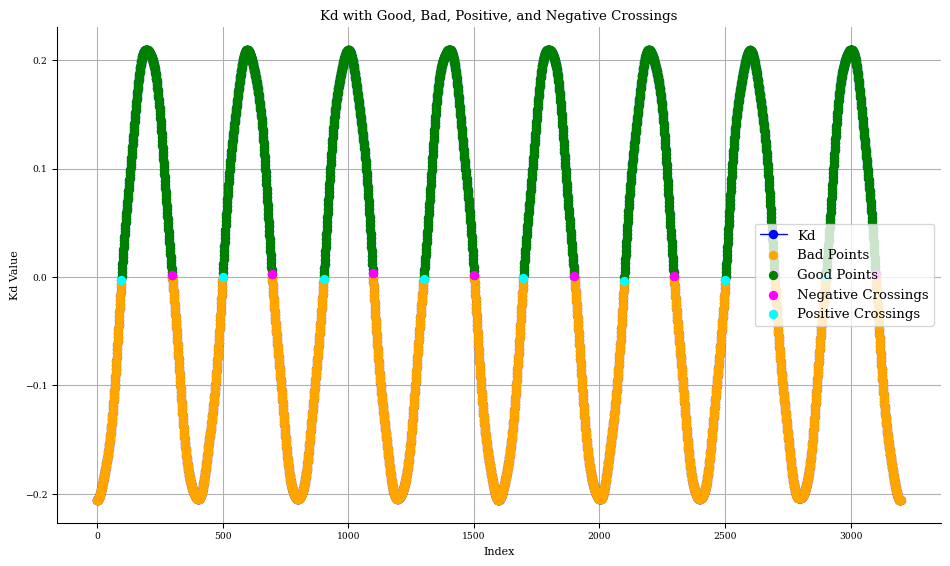

In [34]:
old2_plot_masks(Kd)

In [37]:
Kd_wells,lengths,masks = extract_Kd(Kd,order=True)
lengths

Array([206, 205, 204, 202, 201], dtype=int64)

In [9]:
L_par = get_value(eq,"L_par",grid)
print(L_par)

[7.51917669 7.70622088 7.55658553 7.33213249 7.40695017 7.66881204
 7.6314032 ]


In [9]:
R_eff = get_value(eq,"R_eff",grid)
print(R_eff)

[4.94642624 4.99570127 4.95423529 4.91146654 4.9329721 ]


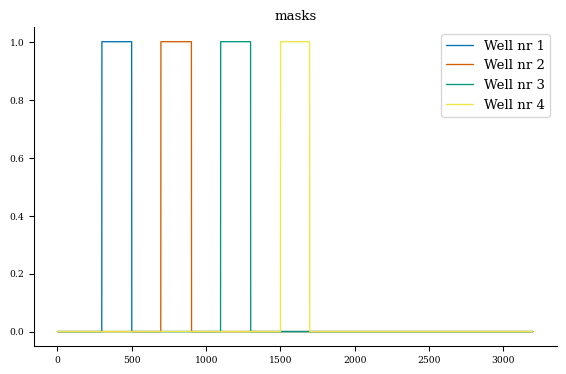

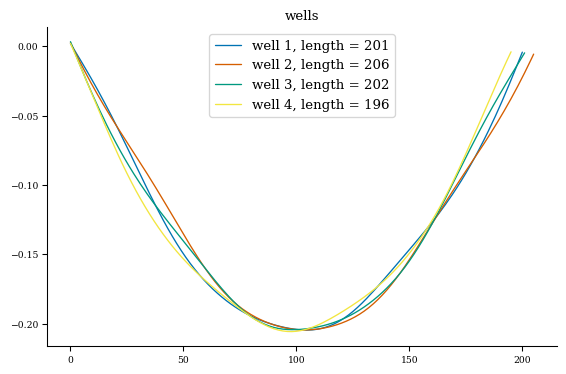

In [365]:
plot_all(Kd,n_wells=5)

In [385]:
dl  = get_value(eq,"|e_zeta|r,a|",grid)
l = get_arc_length(dl,grid)
n_wells = 7
Kd_wells,lengths,masks = extract_Kd(Kd,n_wells=n_wells)
_,_,R_eff = fit_wells(grid.nodes[:,2], Kd_wells, masks, n_wells)
print(R_eff)

[4.94642624 4.99570127 4.95423529 4.91146654 4.9329721  4.99095125
 4.96894916]


In [378]:
R_effs = jnp.array(get_value(eq,"R_eff",grid))
print(R_effs)

[4.94631844 4.99736983 4.9565117  4.91133232 4.93264624 4.992221
 4.97178204]


In [331]:
diff = jnp.divide(jnp.abs(R_eff[1:6]-R_effs),R_effs)*100
print(f"{diff}%")

[0.00639076 0.03422623 0.04762448 0.00853592 0.00444359]%


Iota is 0.4200310370818866
NFP is 2


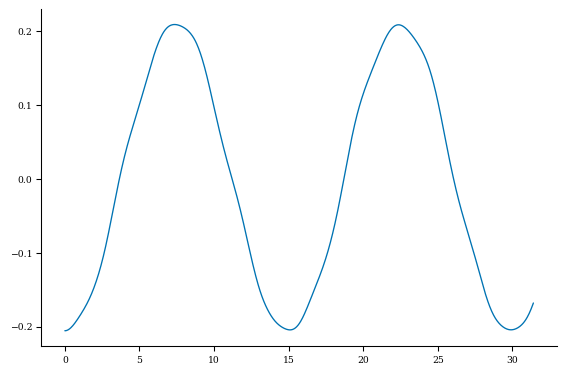

In [394]:
eq = get("precise_QA")
iota_grid = LinearGrid(
    rho=0.5
)
iota = np.abs(eq.compute("iota",iota_grid)["iota"][0])
grid = get_field_line_grid(eq,iota,n_pol=5)
Kd = get_value(eq,"K_d",grid)
print(f"Iota is {iota}")
print(f"NFP is {eq.NFP}")
plt.figure()
plt.plot(grid.nodes[:,2],Kd);

In [395]:
n = find_n_wells(Kd)
print(n)

1
